In [3]:
!pip install networkx matplotlib


  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.2/162.2 kB 77.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 15.1 MB/s eta 0:00:00m eta 0:00:010:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 306.0/306.0 kB 13.6 MB/s eta 0:00:00
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 38.2 MB/s eta 0:00:00m eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 12.0 MB/s eta 0:00:00m eta 0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 5.6 MB/s eta 0:00:00


In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms import bipartite
from networkx.drawing.layout import bipartite_layout

In [2]:
ratings = pd.read_csv('1m/ratings.dat', sep='::', names=['user_id', 'item_id', 'rating', 'timestamp'], engine='python', encoding='latin1')
movies = pd.read_csv('1m/movies.dat', sep='::', names=['movie_id', 'title', 'genres'], engine='python', encoding='latin1')
users = pd.read_csv('1m/users.dat', sep='::', names=['user_id', 'gender', 'age', 'occupation', 'zip_code'], engine='python', encoding='latin1')

In [4]:
# Function to convert data types to native Python types
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        elif isinstance(obj, np.bool_):
            return bool(obj)
        elif isinstance(obj, np.datetime64):
            return obj.item().isoformat()
        else:
            return super(NumpyEncoder, self).default(obj)

# Merge the ratings with the movies data
merged_data = pd.merge(ratings, movies, left_on='item_id', right_on='movie_id')
merged_data['timestamp'] = pd.to_datetime(merged_data['timestamp'], unit='s')
movies_dict = movies.set_index('movie_id').to_dict('index')
user_dict = {}

# Add user information to the user dictionary
for _, row in users.iterrows():
    user_id = row['user_id']
    user_info = {
        "user_id": user_id,
        "gender": row['gender'],
        "age": row['age'],
        "occupation": row['occupation'],
        "zip_code": row['zip_code'],
        "ratings": []
    }
    user_dict[user_id] = user_info

# Add movie ratings to the user dictionary
for _, row in ratings.iterrows():
    user_id = row['user_id']
    movie_id = row['item_id']
    movie_info = movies_dict[movie_id]
    rating_info = {
        'movie_id': movie_id,
        'rating': row['rating'],
        'timestamp': row['timestamp'],
        'title': movie_info['title'],
        'genres': movie_info['genres']
    }
    user_dict[user_id]['ratings'].append(rating_info)

# Save to JSON file using the custom NumpyEncoder
with open('restructured_user_data.json', 'w') as json_file:
    json.dump(user_dict, json_file, cls=NumpyEncoder, indent=4)

print("Restructured user data saved to 'restructured_user_data.json'")

Restructured user data saved to 'restructured_user_data.json'


In [14]:
# Load the combined user data from JSON file
with open('user_data.json', 'r') as json_file:
    user_data = json.load(json_file)

# Initialize the detailed graph
G_detailed = nx.Graph()

# Add users and their information to the detailed graph
for user_id, data in user_data.items():
    G_detailed.add_node(f'user_{user_id}', type='user', user_info=json.dumps(data['user_info']))
    for rating in data['ratings']:
        movie_id = rating['movie_id']
        movie_info = rating['movie_info']
        G_detailed.add_node(f'movie_{movie_id}', type='movie', movie_info=json.dumps(movie_info))
        G_detailed.add_edge(f'user_{user_id}', f'movie_{movie_id}', type='rated', rating=rating['rating'], timestamp=rating['timestamp'])
        
        # Add genre nodes and edges
        genres = movie_info['genres'].split('|')
        for genre in genres:
            if f'genre_{genre}' not in G_detailed:
                G_detailed.add_node(f'genre_{genre}', type='genre', name=genre)
            G_detailed.add_edge(f'movie_{movie_id}', f'genre_{genre}', type='belongs_to')

# Save the graph to a GraphML file
nx.write_graphml(G_detailed, 'knowledge_graph_detailed.graphml')

print("Graph saved to 'knowledge_graph_detailed.graphml'")

Graph saved to 'knowledge_graph_detailed.graphml'


In [15]:
# Calculate the number of reviews per user
user_review_counts = ratings['user_id'].value_counts()

# Display the first few user review counts
print(user_review_counts.head())

user_id
4169    2314
1680    1850
4277    1743
1941    1595
1181    1521
Name: count, dtype: int64


Number of users after filtering: 5979


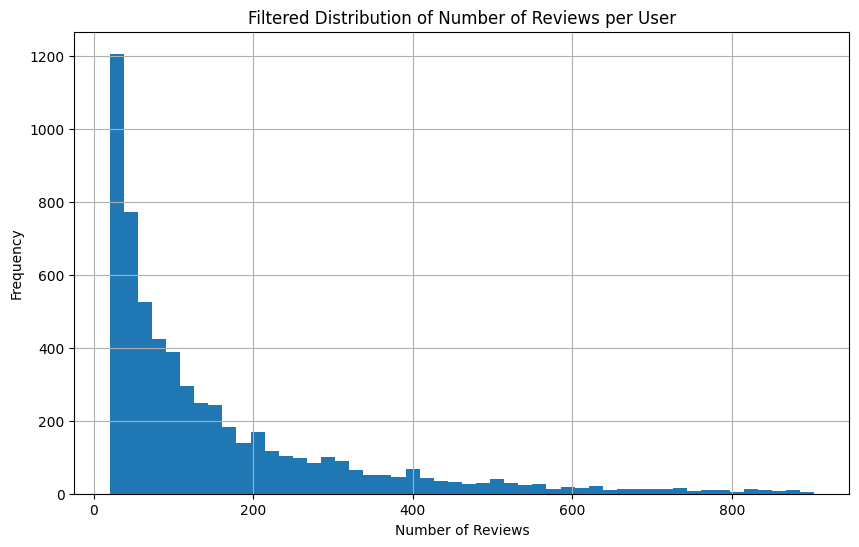

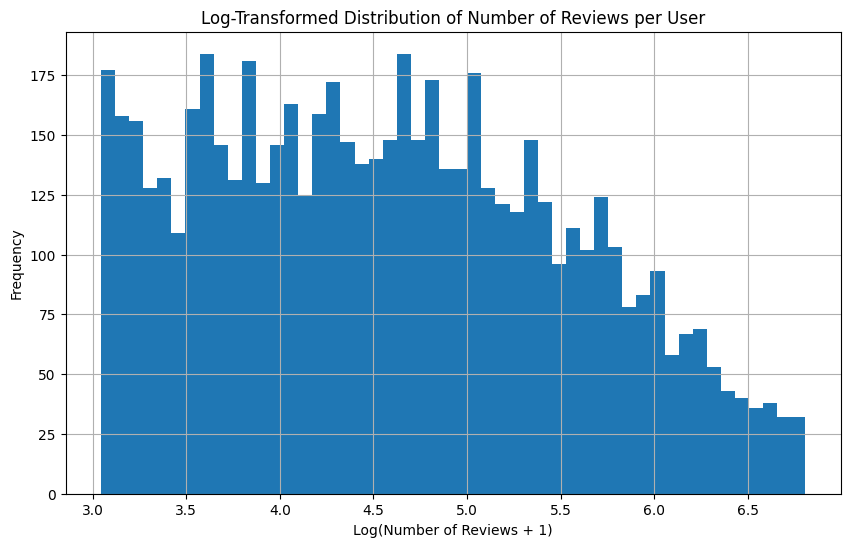

In [16]:
# Calculate the number of reviews per user
user_review_counts = ratings['user_id'].value_counts()

# Define the threshold for filtering out extreme outliers
threshold_low = user_review_counts.quantile(0.00)  # 1st percentile
threshold_high = user_review_counts.quantile(0.99)  # 99th percentile

# Filter users within the threshold
filtered_user_review_counts = user_review_counts[(user_review_counts >= threshold_low) & (user_review_counts <= threshold_high)]

print(f"Number of users after filtering: {len(filtered_user_review_counts)}")

# Plot the filtered distribution
plt.figure(figsize=(10, 6))
filtered_user_review_counts.hist(bins=50)
plt.title('Filtered Distribution of Number of Reviews per User')
plt.xlabel('Number of Reviews')
plt.ylabel('Frequency')
plt.show()

# Apply log transformation to reduce skewness
log_transformed_counts = np.log1p(filtered_user_review_counts)  # log1p to handle zero counts

# Plot the log-transformed distribution
plt.figure(figsize=(10, 6))
log_transformed_counts.hist(bins=50)
plt.title('Log-Transformed Distribution of Number of Reviews per User')
plt.xlabel('Log(Number of Reviews + 1)')
plt.ylabel('Frequency')
plt.show()

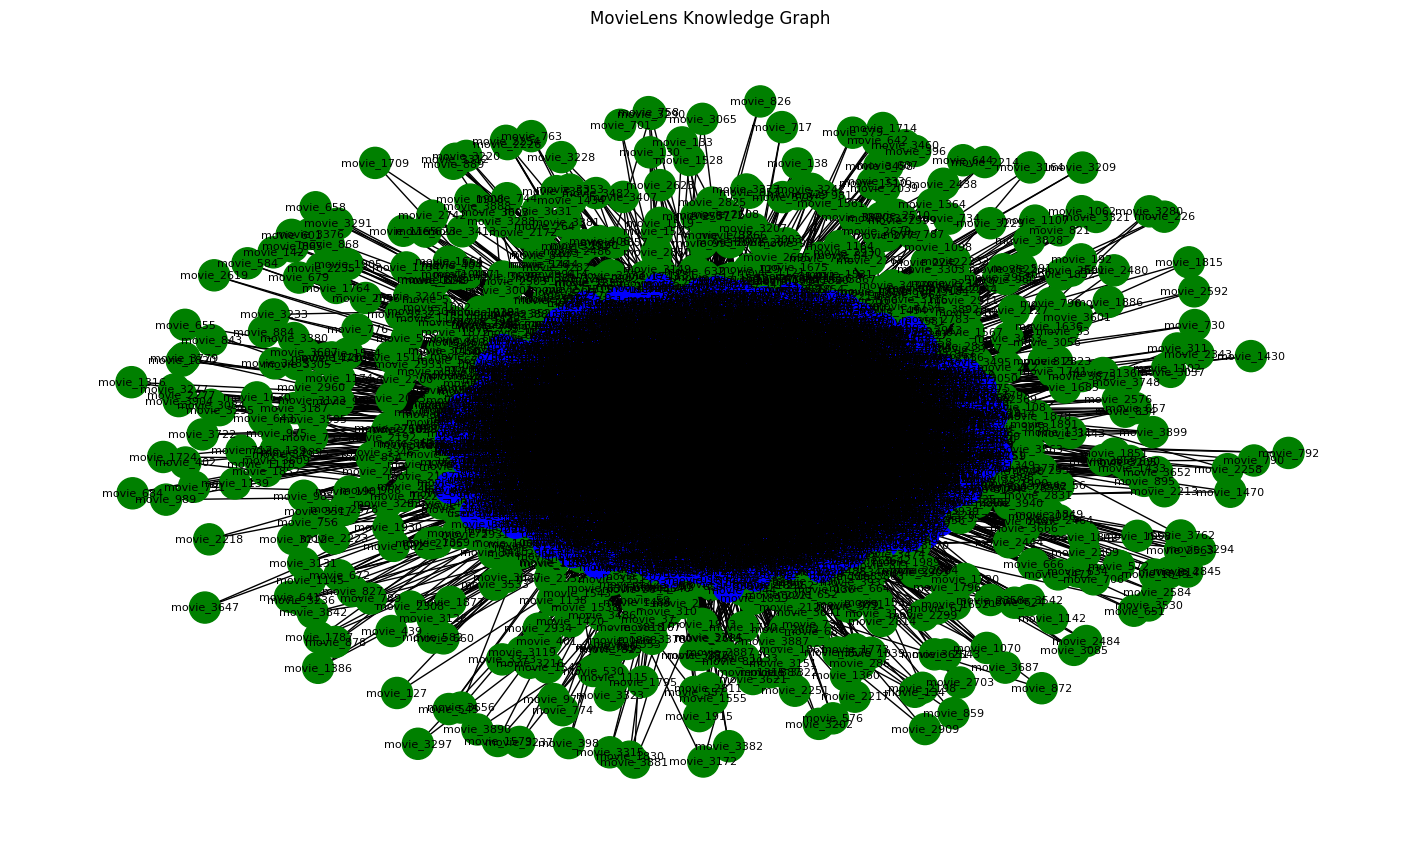

In [18]:
# Draw the graph with node colors based on type
color_map = []
for node in G_detailed:
    if G_detailed.nodes[node]['type'] == 'user':
        color_map.append('blue')
    elif G_detailed.nodes[node]['type'] == 'movie':
        color_map.append('green')
    elif G_detailed.nodes[node]['type'] == 'genre':
        color_map.append('red')

plt.figure(figsize=(14, 8))
pos = nx.spring_layout(G_detailed, k=0.15)  # Adjust layout for better visualization
nx.draw(G_detailed, pos, node_color=color_map, with_labels=True, node_size=500, font_size=8)
plt.title('MovieLens Knowledge Graph')
plt.show()

In [3]:
# Convert timestamp to datetime
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')

# Group by date
ratings_by_date = ratings['timestamp'].dt.date.value_counts().sort_index()


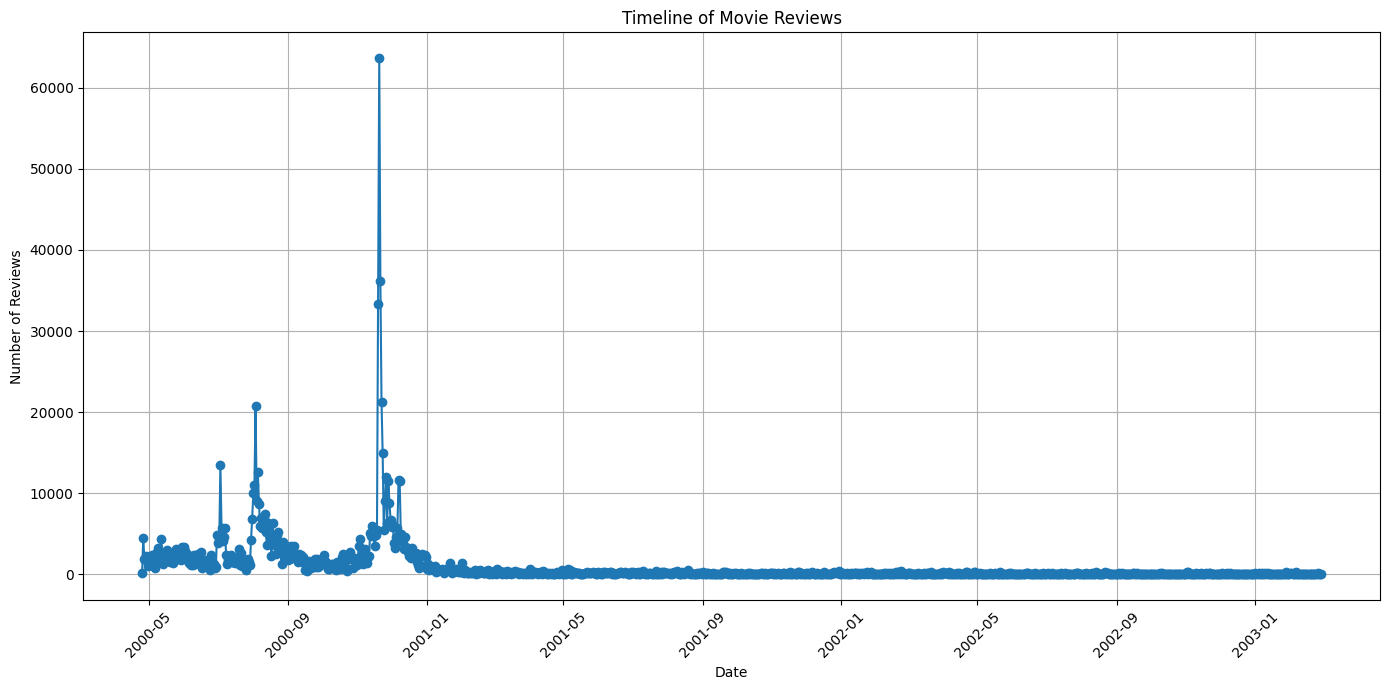

In [4]:
import matplotlib.pyplot as plt

# Plot the timeline
plt.figure(figsize=(14, 7))
plt.plot(ratings_by_date.index, ratings_by_date.values, marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Number of Reviews')
plt.title('Timeline of Movie Reviews')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


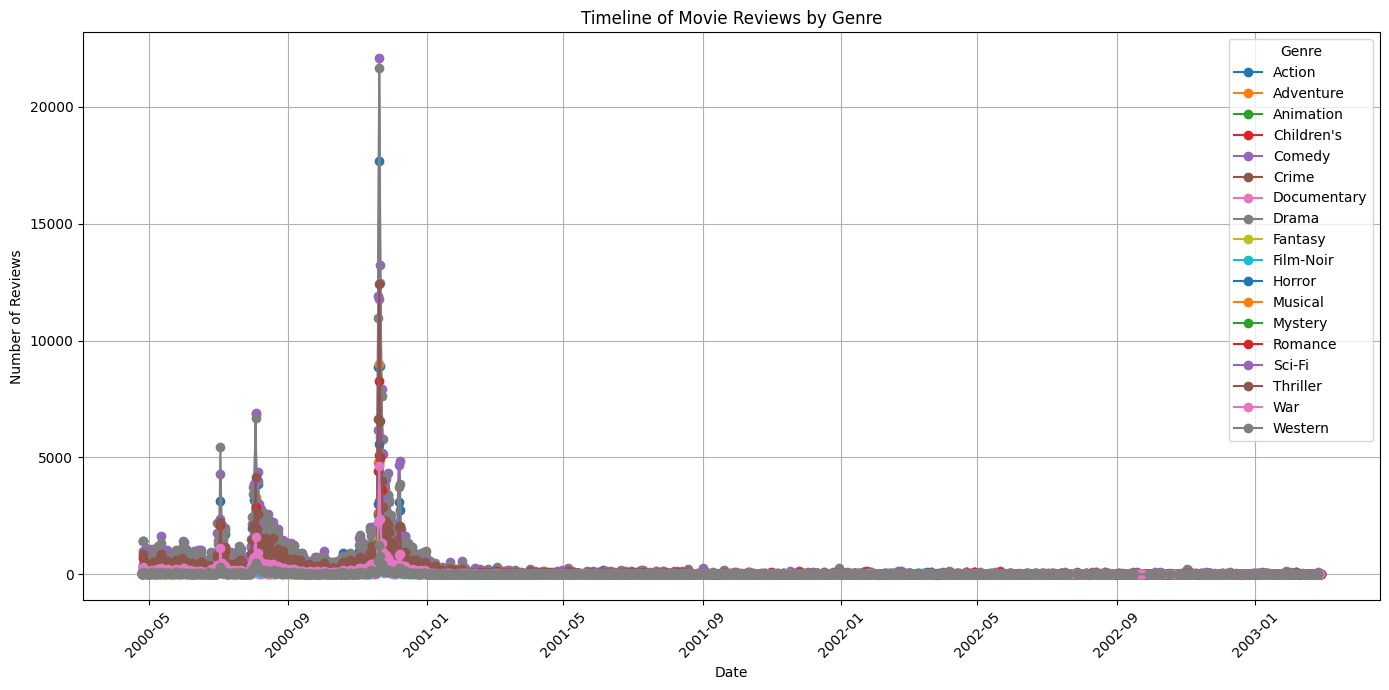

In [5]:
# Merge the ratings with the movies data
merged_data = pd.merge(ratings, movies, left_on='item_id', right_on='movie_id')

# Convert timestamp to datetime
merged_data['timestamp'] = pd.to_datetime(merged_data['timestamp'], unit='s')

# Function to process genres
def process_genres(df):
    df = df.copy()
    df['genres'] = df['genres'].str.split('|')
    df = df.explode('genres').reset_index(drop=True)
    return df

# Process genres
merged_data = process_genres(merged_data)

# Group by date and genre
grouped_by_genre = merged_data.groupby(['genres', merged_data['timestamp'].dt.date]).size().reset_index(name='count')

# Plot the timeline for each genre
genres = grouped_by_genre['genres'].unique()
plt.figure(figsize=(14, 7))

for genre in genres:
    genre_data = grouped_by_genre[grouped_by_genre['genres'] == genre]
    plt.plot(genre_data['timestamp'], genre_data['count'], marker='o', linestyle='-', label=genre)

plt.xlabel('Date')
plt.ylabel('Number of Reviews')
plt.title('Timeline of Movie Reviews by Genre')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title='Genre')
plt.tight_layout()
plt.show()

In [6]:
import plotly.express as px
import plotly.io as pio

pio.renderers.default = 'iframe'

# Create the interactive plot
fig = px.line(grouped_by_genre, x='timestamp', y='count', color='genres',
              title='Timeline of Movie Reviews by Genre',
              labels={'timestamp': 'Date', 'count': 'Number of Reviews', 'genres': 'Genre'})

# Update layout to make it more interactive
fig.update_layout(
    xaxis_title='Date',
    yaxis_title='Number of Reviews',
    legend_title='Genre',
    hovermode='x unified'
)

# Show the plot
fig.show()